### Generate performance table
Michael Nolan

2020.11.04

In [12]:
import torch
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import sys
from glob import glob
import site
site.addsitedir(os.path.curdir + '\..')
from utils import load_parameters
# site.addsitedir("/home/ws5/manolan/ecog_pred/hierarchical_lfads")

In [13]:
#-------------------------------------------------------------------
#-------------------------------------------------------------------

def prep_model(model_name, data_dict, data_suffix, batch_size, device, hyperparams, input_dims=None):
    if model_name == 'lfads_ecog':
        # train_dl, valid_dl, input_dims, plotter = prep_data(data_dict=data_dict, data_suffix=data_suffix, batch_size=batch_size, device=device)
        if not input_dims:
            input_dims = data_dict[f'test_{data_suffix}'].shape[-1]
        model, objective = prep_lfads_ecog(input_dims = input_dims,
                                      hyperparams=hyperparams,
                                      device= device,
                                      dtype=data_dict[f'test_{data_suffix}'].dtype,
                                      dt= data_dict['dt']
                                      )
    return model

#-------------------------------------------------------------------
#-------------------------------------------------------------------

def prep_lfads_ecog(input_dims, hyperparams, device, dtype, dt):
    from objective import LFADS_Loss, LogLikelihoodGaussian
    from lfads import LFADS_Ecog_SingleSession_Net

    model = LFADS_Ecog_SingleSession_Net(input_size           = input_dims,
                                    factor_size          = hyperparams['model']['factor_size'],
                                    g_encoder_size       = hyperparams['model']['g_encoder_size'],
                                    c_encoder_size       = hyperparams['model']['c_encoder_size'],
                                    g_latent_size        = hyperparams['model']['g_latent_size'],
                                    u_latent_size        = hyperparams['model']['u_latent_size'],
                                    controller_size      = hyperparams['model']['controller_size'],
                                    generator_size       = hyperparams['model']['generator_size'],
                                    prior                = hyperparams['model']['prior'],
                                    clip_val             = hyperparams['model']['clip_val'],
                                    dropout              = hyperparams['model']['dropout'],
                                    do_normalize_factors = hyperparams['model']['normalize_factors'],
                                    max_norm             = hyperparams['model']['max_norm'],
                                    device               = device).to(device)
    
    loglikelihood = LogLikelihoodGaussian()

    objective = LFADS_Loss(loglikelihood            = loglikelihood,
                           loss_weight_dict         = {'kl': hyperparams['objective']['kl'], 
                                                       'l2': hyperparams['objective']['l2']},
                           l2_con_scale             = hyperparams['objective']['l2_con_scale'],
                           l2_gen_scale             = hyperparams['objective']['l2_gen_scale']).to(device)

    return model, objective

#-------------------------------------------------------------------
#-------------------------------------------------------------------
    
def prep_data(data_dict, data_suffix, batch_size, device, input_size=None):
    train_data  = torch.Tensor(data_dict['train_%s'%data_suffix])
    valid_data  = torch.Tensor(data_dict['valid_%s'%data_suffix])
    
    num_trials, num_steps, _ = train_data.shape
    if not input_size: # very hacky, I apologize to the lord
        input_size = train_data.shape(-1)
    
    train_ds    = EcogTensorDataset(train_data,device=device)
    valid_ds    = EcogTensorDataset(valid_data,device=device)
    
    train_dl    = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle=True)
    valid_dl    = torch.utils.data.DataLoader(valid_ds, batch_size = batch_size)
    
    TIME = torch._np.arange(0, num_steps*data_dict['dt'], data_dict['dt'])
    
    train_truth = {}
    if 'train_rates' in data_dict.keys():
        train_truth['rates'] = data_dict['train_rates']
    if 'train_latent' in data_dict.keys():
        train_truth['latent'] = data_dict['train_latent']
    if 'valid_spikes' in data_dict.keys():
        train_truth['spikes'] = data_dict['train_spikes']
        
    valid_truth = {}
    if 'valid_rates' in data_dict.keys():
        valid_truth['rates'] = data_dict['valid_rates']
    if 'valid_latent' in data_dict.keys():
        valid_truth['latent'] = data_dict['valid_latent']
    if 'valid_spikes' in data_dict.keys():
        valid_truth['spikes'] = data_dict['valid_spikes']

    plotter = None
    # plotter = {'train' : Plotter(time=TIME, truth=train_truth),
    #            'valid' : Plotter(time=TIME, truth=valid_truth)}
    
    return train_dl, valid_dl, input_size, plotter

#-------------------------------------------------------------------
#-------------------------------------------------------------------

from torch.utils.data.dataset import Dataset
class EcogTensorDataset(Dataset):
    r"""Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Arguments:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """

    def __init__(self, *tensors, device='cpu'):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.device = device

    def __getitem__(self, index):
        return tuple(tensor[index].to(self.device) for tensor in self.tensors)

    def __len__(self):
        return self.tensors[0].size(0)

#-------------------------------------------------------------------
#-------------------------------------------------------------------

import h5py
def read_data(data_fname,keys):
    
    """ Read saved data in HDF5 format.

    Args:
        data_fname: The filename of the file from which to read the data.
    Returns:
        A dictionary whose keys will vary depending on dataset (but should
        always contain the keys 'train_data' and 'valid_data') and whose
        values are numpy arrays.
    """
    try:
        with h5py.File(data_fname, 'r') as hf:
            data_dict = {k: np.array(v) for k, v in hf.items() if k in keys}
            return data_dict
    except IOError:
        print("Cannot open %s for reading." % data_fname)
        raise

#-------------------------------------------------------------------
#-------------------------------------------------------------------

def compute_prediction_metrics(test_data,pred,pred_window_T,bin_T,p_lim=[2.5, 97.5],srate=250):
    n_trial, n_sample, n_ch = test_data.shape
    time = np.arange(pred_window_T*srate)/srate
    bin_T_left_edge = np.arange(pred_window_T,step=bin_T)
    bin_T_right_edge = bin_T_left_edge + bin_T
    n_time_bin = len(bin_T_left_edge)
    mae, rmse, rpe = compute_prediction_error(test_data, pred)
    mae_bin = np.empty((n_trial,n_time_bin))
    rmse_bin = np.empty((n_trial,n_time_bin))
    rpe_bin = np.empty((n_trial,n_time_bin))
    for tb_idx in range(n_time_bin):
        bin_idx = np.logical_and(time >= bin_T_left_edge[tb_idx], time < bin_T_right_edge[tb_idx])
        mae_bin[:,tb_idx], rmse_bin[:,tb_idx], rpe_bin[:,tb_idx] = compute_prediction_error(test_data[:,bin_idx,:],pred[:,bin_idx,:])
    # get stats from sample distributions
    stat_dict = {
        'mae_mean': mae.mean(),
        'mae_95ci': np.percentile(mae,p_lim),
        'mae_bin_mean': mae_bin.mean(axis=0),
        'mae_bin_95ci': np.percentile(mae_bin,p_lim,axis=0),
        'rmse_mean': rmse.mean(),
        'rmse_95ci': np.percentile(rmse,p_lim),
        'rmse_bin_mean': rmse_bin.mean(axis=0),
        'rmse_bin_95ci': np.percentile(rmse_bin,p_lim,axis=0),
        'rpe_mean': rpe.mean(),
        'rpe_95ci': np.percentile(rpe,p_lim),
        'rpe_bin_mean': np.nanmean(rpe_bin,axis=0),
        'rpe_bin_95ci': np.nanpercentile(rpe_bin,p_lim,axis=0),
        # 'corr_mean': np.tanh(np.arctanh(corr).mean(axis=0)),
        # 'corr_95ci': np.percentile(corr,p_lim,axis=0),
        # 'corr_bin_mean': np.tanh(np.arctanh(corr_bin).mean(axis=0)),
        # 'corr_bin_95ci': np.percentile(corr_bin,p_lim,axis=0)
    }
    return stat_dict, bin_T_left_edge

#-------------------------------------------------------------------
#-------------------------------------------------------------------

def compute_prediction_error(trg,pred):
    err = trg - pred
    mae = np.abs(err).mean(axis=(1,2))
    rmse = np.sqrt((err**2).mean(axis=(1,2)))
    trg_std = trg.std(axis=1)
    rpe = (err.std(axis=1)/trg_std).mean(axis=-1)
    rpe[np.isinf(rpe)] == np.nan
    return mae, rmse, rpe

#-------------------------------------------------------------------
#-------------------------------------------------------------------

def bootstrap_est(data,n_boot,f):
    n_sample = data.shape[0]
    est = []
    for n in range(n_boot):
        _idx = np.random.choice(np.arange(n_sample),size=n_sample,replace=True)
        est.append(f(data[_idx,]))
    est = np.stack(est,axis=0)
    return est

In [14]:
def get_model_params(model_dir_path):
    # break down model_dir_path
    model_key_list = model_dir_path.split("\\")
    conf_str = model_key_list[-1]
    model_name = model_key_list[-2]
    data_keys = model_key_list[-3].split("_")
    if len(data_keys) > 2:
        data_suffix = 'ecog_' + data_keys[2]
    else:
        data_suffix = 'ecog'
    # break down conf_str
    conf_key_list = conf_str.split("_")
    n_ch = int(conf_key_list[-4][3:])
    seq_len = int(conf_key_list[-3][6:])
    return model_name, data_suffix, n_ch, seq_len

#-------------------------------------------------------------------
#-------------------------------------------------------------------

def load_configure_model_data(model_dir_path,data_path,hyperparameter_path,std_thresh=0.5):
    model_name, data_suffix, n_ch, seq_len = get_model_params(model_dir_path)
    batch_size = 1000
    device = 'cpu'
    hyperparams = load_parameters(hyperparameter_path)
    data_dict   = read_data(data_path,keys = [f'test_{data_suffix}','dt'])
    model= prep_model(model_name = model_name,
                                            data_dict = data_dict,
                                            data_suffix = data_suffix,
                                            batch_size = batch_size,
                                            device = device,
                                            hyperparams = hyperparams,
                                            input_dims= n_ch)
    checkpoint_file_path = os.path.join(model_dir_path,"checkpoints","best.pth")
    checkpoint = torch.load(checkpoint_file_path,map_location=device)
    model.load_state_dict(checkpoint['net'])
    # grab data
    test_data = np.array(data_dict[f"test_{data_suffix}"][:,:seq_len,10:10+n_ch],dtype=np.float32)
    test_data_mask = test_data.std(axis=(1,2)) < std_thresh
    test_data = test_data[~test_data_mask,:,:]
    return model, test_data

#-------------------------------------------------------------------
#-------------------------------------------------------------------

def compute_model_outputs(model,test_data):
    model.eval()
    with torch.no_grad():
        recon, (factors, generators, gen_inputs) = model.forward_all(test_data)
    return recon, factors, generators

#-------------------------------------------------------------------
#-------------------------------------------------------------------

def compute_metric_table(test_data,recon,model_dir_path):
    n_trial, n_sample, n_ch = test_data.shape
    model_name, data_suffix, n_ch, seq_len = get_model_params(model_dir_path)
    # compute metrics
    mse = np.mean((recon['data'].numpy() - test_data)**2,axis=(1,2))
    rmse = np.sqrt(mse)
    mae = np.abs(recon['data'].numpy() - test_data).mean(axis=(1,2))
    trg_std = np.std(test_data, axis=(1,2))
    rpe = rmse/trg_std
    corr = np.array([np.corrcoef(t.T,r.T)[0,1] for t,r in zip(test_data.reshape(n_trial,-1),recon['data'].numpy().reshape(n_trial,-1))])
    # compute statistics
    f_est = lambda x: x.mean()
    f_zcorr_est = lambda x: np.tanh(x).mean()
    n_boot = 1000
    mse_bsd = bootstrap_est(mse,n_boot,f_est)
    rmse_bsd = bootstrap_est(rmse,n_boot,f_est)
    mae_bsd = bootstrap_est(mae,n_boot,f_est)
    rpe_bsd = bootstrap_est(rpe,n_boot,f_est)
    zcorr_bsd = bootstrap_est(corr,n_boot,f_zcorr_est) # fisher transform for better stats
    stat_dict = {
        'model_path': model_dir_path,
        'model_name': model_name,
        'data_suffix': data_suffix,
        'n_ch': n_ch,
        'seq_len': seq_len,
        'seq_t': seq_len/250, # whoopsie with the magic number
        'mse_mean': [mse_bsd.mean()],
        'mse_mean_2.5ci': [np.percentile(mse_bsd,2.5)],
        'mse_mean_97.5ci': [np.percentile(mse_bsd,97.5)],
        'mse_2.5ci': [np.percentile(mse,2.5)],
        'mse_97.5ci': [np.percentile(mse,97.5)],
        'rmse_mean': [rmse_bsd.mean()],
        'rmse_mean_2.5ci': [np.percentile(rmse_bsd,2.5)],
        'rmse_mean_97.5ci': [np.percentile(rmse_bsd,97.5)],
        'rmse_2.5ci': [np.percentile(rmse,2.5)],
        'rmse_97.5ci': [np.percentile(rmse,97.5)],
        'mae_mean': [mae_bsd.mean()],
        'mae_mean_2.5ci': [np.percentile(mae_bsd,2.5)],
        'mae_mean_97.5ci': [np.percentile(mae_bsd,97.5)],
        'mae_2.5ci': [np.percentile(mae,2.5)],
        'mae_97.5ci': [np.percentile(mae,97.5)],
        'rpe_mean': [rpe_bsd.mean()],
        'rpe_mean_2.5ci': [np.percentile(rpe_bsd,2.5)],
        'rpe_mean_97.5ci': [np.percentile(rpe_bsd,97.5)],
        'rpe_2.5ci': [np.percentile(rpe,2.5)],
        'rpe_97.5ci': [np.percentile(rpe,97.5)],
        'corr_mean': [np.arctanh(zcorr_bsd.mean())],
        'corr_mean_2.5ci': [np.arctanh(np.percentile(zcorr_bsd,2.5))],
        'corr_mean_97.5ci': [np.arctanh(np.percentile(zcorr_bsd,97.5))],
        'corr_2.5ci': [np.percentile(corr,2.5)],
        'corr_97.5ci': [np.percentile(corr,97.5)],
    }
    stat_table = pd.DataFrame.from_dict(stat_dict)
    metric_dict = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'rpe': rpe,
        'corr': corr,
    }
    return stat_table, metric_dict

#-------------------------------------------------------------------
#-------------------------------------------------------------------

def get_model_performance_stat_table(model_dir_path,data_path,hyperparameter_path):
    print(f'loading model from:\t{model_dir_path}')
    model, test_data = load_configure_model_data(model_dir_path,data_path,hyperparameter_path)
    print('computing test data reconstructions...')
    recon, factors, generators = compute_model_outputs(model,torch.tensor(test_data))
    print('computing metric statistics...')
    stat_table, metric_dict = compute_metric_table(test_data,recon,model_dir_path)
    return stat_table, metric_dict

In [15]:
def plot_loss_curves(model_dir):
    # get loss curves
    tensorboard_dir = os.path.join(model_dir,'tensorboard')
    loss_dirs = glob(os.path.join(tensorboard_dir,'*_Loss_*'))
    loss_dict = {}
    for loss_dir in loss_dirs:
        loss_base = os.path.basename(loss_dir)
        ea = event_accumulator.EventAccumulator(os.path.join(tensorboard_dir,loss_dir))
        ea.Reload()
        loss_keys = ea.Tags()['scalars']
        for loss_key in loss_keys:
            _loss_data = np.array(ea.Scalars(loss_key))[:,-1]
            loss_dict[loss_base] = _loss_data
    loss_data = pd.DataFrame(loss_dict)
    # plot loss curves
    n_c = len(loss_dirs)
    n_r = 1
    fig, ax = plt.subplots(1,1,dpi=150,constrained_layout=True)
    sns.lineplot(data=loss_data,ax=ax)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title('Training Loss')
    return fig, loss_data

def plot_test_data_fits(recon,test_data,n,srate,metrics):
    # assume 1ch for now
    n_trials = test_data.shape[0]
    n_time = test_data.shape[1]
    time = np.arange(n_time)/srate
    trial_idx = np.random.choice(np.arange(n_trials),n,replace=False)
    n_r = int(np.ceil(np.sqrt(n)))
    n_c = int(np.ceil(n/n_r))
    fig, ax = plt.subplots(n_r,n_c,dpi=150,constrained_layout=True,sharex=True,figsize=(6,6))
    ax = ax.reshape(-1)
    for idx, t_idx in enumerate(trial_idx):
        r_idx = idx // n_c
        c_idx = idx % n_c
        ax[idx].plot(time,test_data[t_idx,:,0],label='target')
        ax[idx].plot(time,recon['data'][t_idx,:,0],label='recon.')
        if r_idx == n_r - 1:
            ax[idx].set_xlabel('time (s)')
        if c_idx == 0:
            ax[idx].set_ylabel('a.u.')
        ax[idx].set_title(f'trial {t_idx}')
        metric_str = f"mse: {metrics['mse'][t_idx]:0.3f}\nrpe: {metrics['rpe'][t_idx]:0.3f}\ncorr: {metrics['corr'][t_idx]:0.3f}"
        text_x = ax[idx].get_xlim()[0]
        text_y = ax[idx].get_ylim()[0]
        ax[idx].text(text_x,text_y,metric_str,horizontalalignment='left',verticalalignment='bottom',fontsize=8,bbox=dict(alpha=0.1))
    ax[0].legend(loc=0)
    return fig, ax

def plot_test_data_fits_psd(recon, test_data, srate, n_boot):
    # power features
    from scipy.signal import welch, detrend
    trial_mask = test_data[:,:,0].std(axis=1) < 0.5
    f_psd, data_psd = welch(detrend(test_data[~trial_mask,],type='linear',axis=-2),fs=250,axis=1)
    _, recon_psd = welch(detrend(recon['data'][~trial_mask,],type='linear',axis=-2),fs=250,axis=1)
    f_est = lambda x: x.mean(axis=0)
    data_psd_bsd = bootstrap_est(data_psd[:,:,0], n_boot, f_est)
    data_psd_mean = data_psd_bsd.mean(axis=0)
    data_psd_95ci = np.percentile(data_psd_bsd,[2.5, 97.5],axis=0)
    recon_psd_bsd = bootstrap_est(recon_psd[:,:,0], n_boot, f_est)
    recon_psd_mean = recon_psd_bsd.mean(axis=0)
    recon_psd_95ci = np.percentile(recon_psd_bsd,[2.5, 97.5],axis=0)
    # diff_psd = 10*np.log10(recon_psd[:,:,0])-10*np.log10(data_psd[:,:,0])
    diff_psd = recon_psd[:,:,0]/data_psd[:,:,0]
    diff_psd_bsd = bootstrap_est(diff_psd,n_boot,f_est)
    diff_psd_mean = diff_psd_bsd.mean(axis=0)
    diff_psd_95ci = np.percentile(diff_psd_bsd,[2.5, 97.5],axis=0)
    fig, ax = plt.subplots(1,1,dpi=100,sharex=True)
    ax.fill_between(f_psd, 10*np.log10(data_psd_95ci[0,:]), 10*np.log10(data_psd_95ci[1,:]),alpha=0.2,label='data 95% ci')
    ax.plot(f_psd, 10*np.log10(data_psd_mean), label='data mean');
    ax.fill_between(f_psd, 10*np.log10(recon_psd_95ci[0,:]), 10*np.log10(recon_psd_95ci[1,:]),alpha=0.2,label='recon. 95% ci')
    ax.plot(f_psd, 10*np.log10(recon_psd_mean), label='recon. mean');
    ax.legend(loc=0)
    # ax[1].fill_between(f_psd, 10*np.log10(diff_psd_95ci[0,:]), 10*np.log10(diff_psd_95ci[1,:]), color='k', alpha=0.2, label='diff 95% ci')
    # ax[1].plot(f_psd, 10*np.log10(diff_psd_mean), color='k', label='diff. mean')
    # ax[1].legend(loc=0)
    ax.set_xlabel('freq. (Hz)')
    ax.set_ylabel('PSD (dBu)')
    ax.set_title('Power Spectral Density, Data v. Reconstruction')
    return fig, ax

def model_visualization(model_dir_path,data_path,hyperparameter_path,n,srate,n_boot,metrics):
    print(f'loading model from:\t{model_dir_path}')
    model, test_data = load_configure_model_data(model_dir_path,data_path,hyperparameter_path)
    print('computing test data reconstructions...')
    recon, factors, generators = compute_model_outputs(model,torch.tensor(test_data))
    print('Generating test plots...')
    f_trace, _ = plot_test_data_fits(recon, test_data, n, srate, metrics)
    f_psd, _ = plot_test_data_fits_psd(recon, test_data, srate, n_boot)
    return f_trace, f_psd

In [16]:
# hyperparameter_path = "C:\\Users\\mickey\\aoLab\\code\\hierarchical_lfads\\hyperparameters\\ecog\\lfads_ecog_4.yaml"
# data_path = "D:\\Users\\mickey\\Data\\datasets\\ecog\\goose_wireless\\gw_250_fl0u10"
data_path = "D:\\Users\\mickey\\Data\\datasets\\ecog\\goose_wireless\\gw_250"
overwrite = False
# assert os.path.exists(hyperparameter_path), "hyperparameter file not found."
assert os.path.exists(data_path), "data file not found."
# model_dir = "D:\\Users\\mickey\\Data\\models\\pyt\\lfads\\gw_250_fl0u10\\lfads_ecog\\"
model_dir = "D:\\Users\\mickey\\Data\\models\\pyt\\lfads\\gw_250\\lfads_ecog\\"
# model_dir_list = glob(os.path.join(model_dir,"cenc0_cont0_fact128_genc256_gene256_glat256_nch*_seqlen*_ulat0_orion-l1"))
# model_dir_list = glob(os.path.join(model_dir,"cenc0_cont0_fact256_genc256_gene256_glat256_nch*_seqlen*_ulat0_orion-"))
model_dir_list = glob(os.path.join(model_dir,"cenc0_cont0_fact128_genc1024_gene1024_glat1024_nch*_seqlen*_ulat0_orion-"))
# model_dir_list = list(set(model_dir_list) | set(glob(os.path.join(model_dir,"cenc0_cont0_fact128_genc1024_gene1024_glat1024_nch*_seqlen*_ulat0_orion-"))))
metric_stat_table_file = os.path.join(model_dir,"stat_table.csv")
if os.path.exists(metric_stat_table_file) and not overwrite:
    metric_stat_table = pd.read_csv(metric_stat_table_file)
    run_model_dir_list = list(metric_stat_table['model_path'])
    model_dir_list = list(set(model_dir_list) - set(run_model_dir_list))
    metric_stat_table = [pd.read_csv(metric_stat_table_file)]
else:
    metric_stat_table = []
print(f"unassessed models found:\t{len(model_dir_list)}")
print(model_dir_list)

unassessed models found:	1
['D:\\Users\\mickey\\Data\\models\\pyt\\lfads\\gw_250\\lfads_ecog\\cenc0_cont0_fact128_genc256_gene256_glat256_nch1_seqlen50_ulat0_orion-l1']


  0%|          | 0/1 [00:00<?, ?it/s]loading model from:	D:\Users\mickey\Data\models\pyt\lfads\gw_250\lfads_ecog\cenc0_cont0_fact128_genc256_gene256_glat256_nch1_seqlen50_ulat0_orion-l1
computing test data reconstructions...
computing metric statistics...
loading model from:	D:\Users\mickey\Data\models\pyt\lfads\gw_250\lfads_ecog\cenc0_cont0_fact128_genc256_gene256_glat256_nch1_seqlen50_ulat0_orion-l1
computing test data reconstructions...
Generating test plots...
100%|██████████| 1/1 [00:44<00:00, 44.50s/it]
   Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  \
0         0.0           0.0             0.0   
1         1.0           1.0             0.0   
2         2.0           0.0             NaN   
3         0.0           NaN             NaN   
4         0.0           NaN             NaN   
0         NaN           NaN             NaN   

                                          model_path  model_name data_suffix  \
0  D:\Users\mickey\Data\models\pyt\lfads\gw_250\l...  lfads_ecog        eco

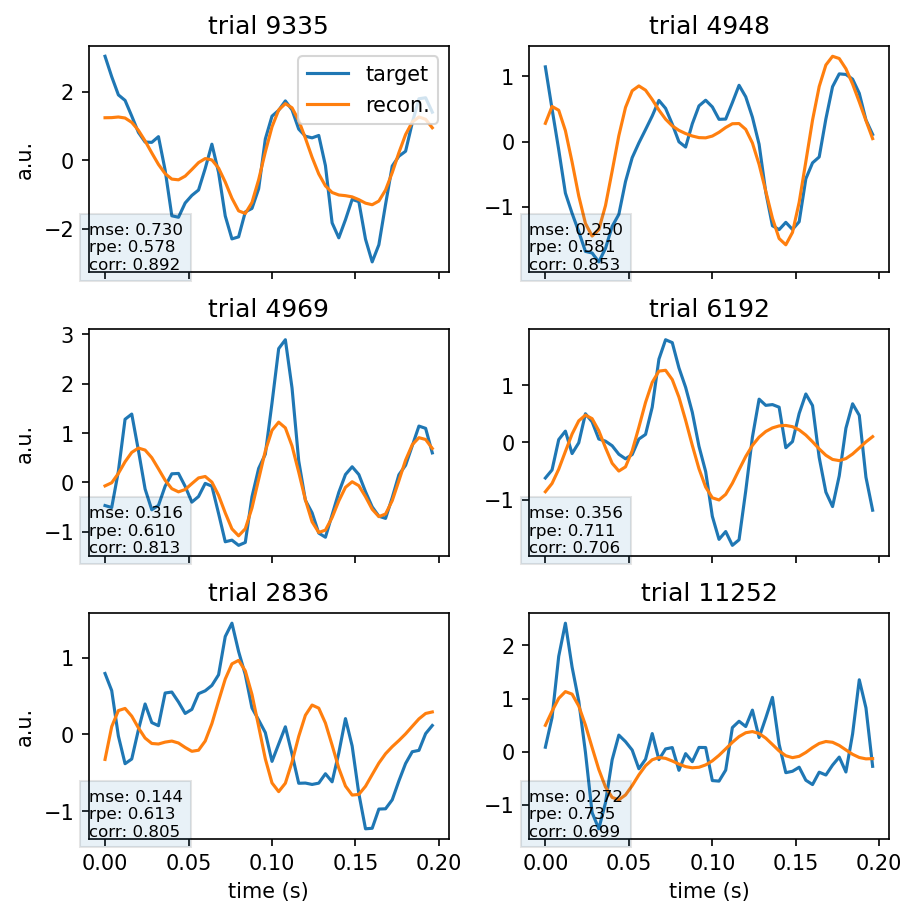

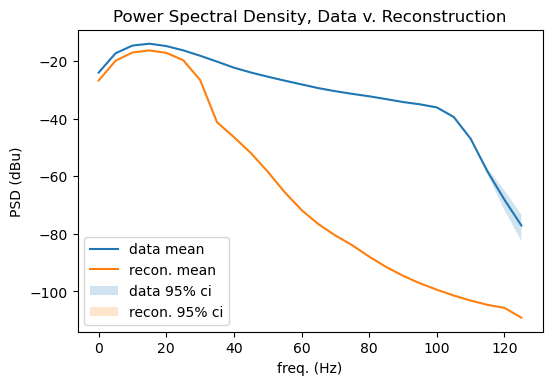

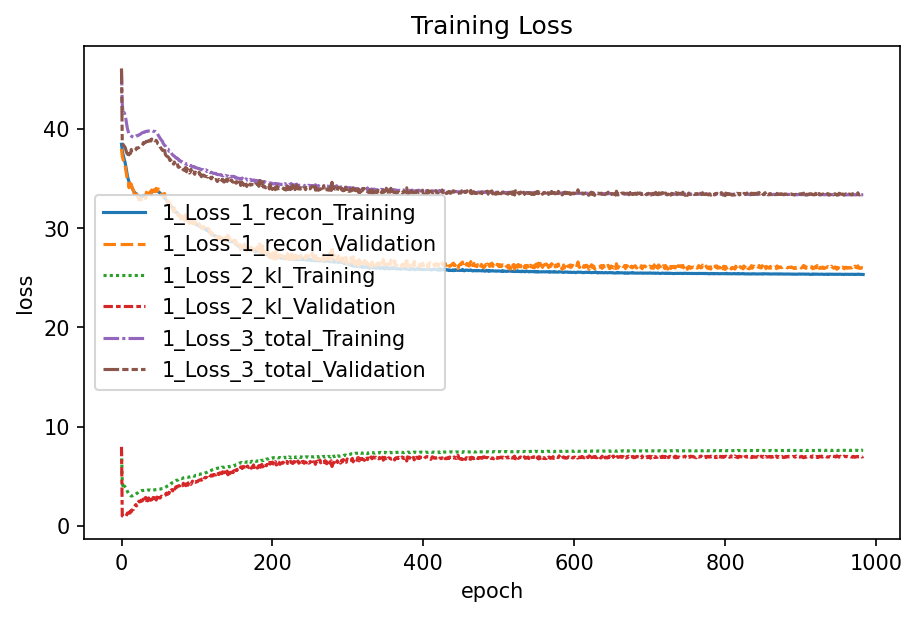

In [18]:
n_trace = 6
srate = 250
n_boot = 500
metric_list = []
for model_dir in tqdm(model_dir_list):
    hyperparameter_path = os.path.join(model_dir,'hyperparameters.yaml')
    metric_stat_table_row, metrics = get_model_performance_stat_table(model_dir,data_path,hyperparameter_path)
    f_trace, f_psd = model_visualization(model_dir,data_path,hyperparameter_path,n_trace,srate,n_boot,metrics)
    f_loss, loss_data = plot_loss_curves(model_dir)
    metric_stat_table.append(metric_stat_table_row)
    metric_list.append(metrics)
    # save figures
    if not os.path.exists(os.path.join(model_dir,'figs')):
        os.makedirs(os.path.join(model_dir,'figs'))
    f_trace.savefig(os.path.join(model_dir,'figs','trace.png'))
    f_psd.savefig(os.path.join(model_dir,'figs','psd.png'))
    f_loss.savefig(os.path.join(model_dir,'figs','loss.png'))
metric_stat_table = pd.concat(metric_stat_table)
print(metric_stat_table)
if os.path.exists(metric_stat_table_file):
    os.remove(metric_stat_table_file)
metric_stat_table.to_csv(metric_stat_table_file)